In [ ]:
import os
import sys
import subprocess

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/img_align_celeba.zip'

In [ ]:
import zipfile
extract_path = '/content/img_align_celeba'
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"압축 해제 완료: {extract_path}")
print(f"파일 목록: {os.listdir(extract_path)[:10]}")  # 첫 10개 파일 확인

압축 해제 완료: /content/img_align_celeba
파일 목록: ['img_align_celeba']


In [ ]:
IMG_SIZE = 64
NOISE_DIM = 100
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0002
BETA_1 = 0.5

def preprocess_image(img_path):

    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1
    return img

def load_dataset(folder_path, batch_size):

    img_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.jpg', '.jpeg', '.png'))]
    dataset = tf.data.Dataset.from_tensor_slices(img_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Generator
def build_generator():
    model = Sequential([
        layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((4, 4, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(4, 4), padding='same', activation='tanh'),
    ])
    return model

# Discriminator
def build_discriminator():
    model = Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1),
    ])
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(epoch, test_input):
    predictions = generator(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')

    plt.savefig(f'gan_image_epoch_{epoch}.png')
    plt.show()

def train(dataset, epochs):
    fixed_noise = tf.random.normal([16, NOISE_DIM])

    for epoch in range(epochs):
        for real_images in dataset:
            gen_loss, disc_loss = train_step(real_images)

        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}')

        if (epoch + 1) % 2 == 0:  # 2 에폭마다 이미지 생성 및 저장
            generate_and_save_images(epoch + 1, fixed_noise)

folder_path = '/content/img_align_celeba/img_align_celeba'

celeba_dataset = load_dataset(folder_path, BATCH_SIZE)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
discriminator_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


c

Epoch 1/10, Generator Loss: 2.9016, Discriminator Loss: 0.5704
Epoch 2/10, Generator Loss: 2.0222, Discriminator Loss: 0.6206


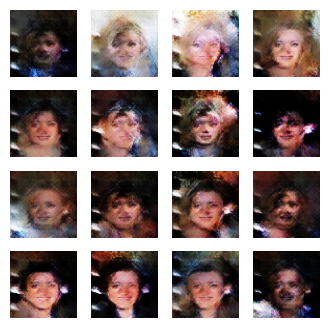

Epoch 3/10, Generator Loss: 2.6100, Discriminator Loss: 0.4647
Epoch 4/10, Generator Loss: 3.8665, Discriminator Loss: 0.6780


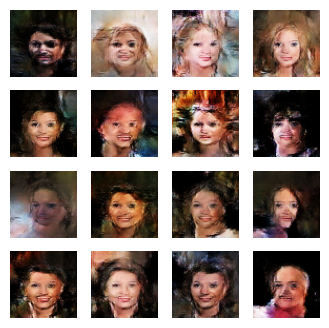

Epoch 5/10, Generator Loss: 2.1060, Discriminator Loss: 0.4635
Epoch 6/10, Generator Loss: 1.4660, Discriminator Loss: 0.5235


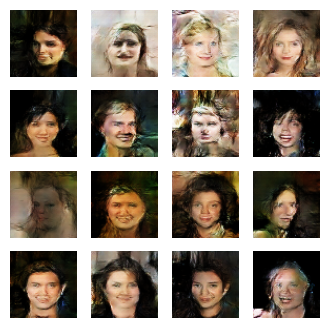

Epoch 7/10, Generator Loss: 1.9834, Discriminator Loss: 0.4998
Epoch 8/10, Generator Loss: 3.2739, Discriminator Loss: 0.2634


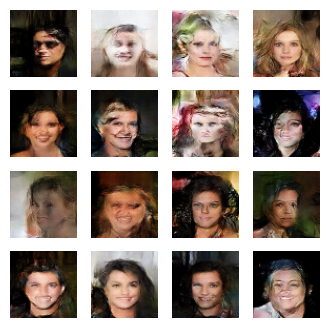

Epoch 9/10, Generator Loss: 2.7063, Discriminator Loss: 0.4704
Epoch 10/10, Generator Loss: 2.3490, Discriminator Loss: 0.5533


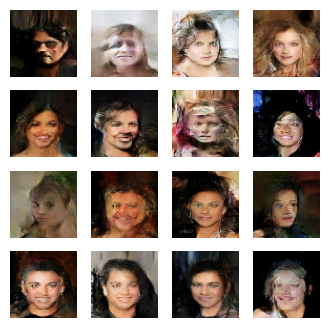

In [ ]:
train(celeba_dataset, EPOCHS)

d

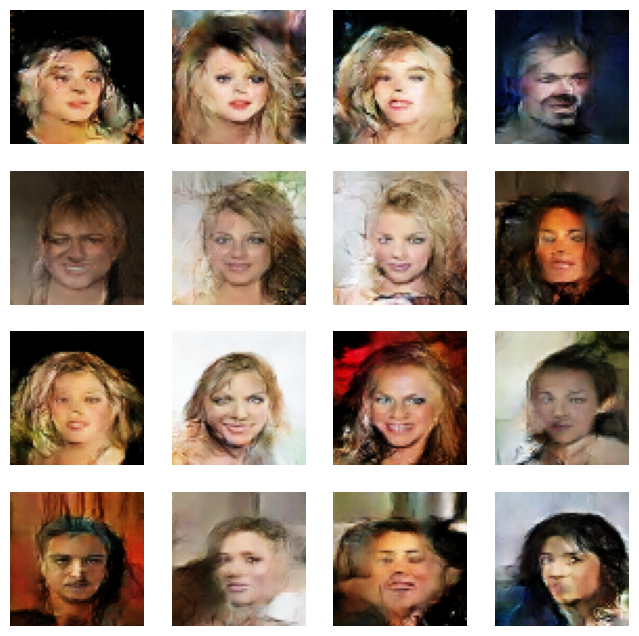

In [ ]:
def visualize_generated_images(generator, num_images=16):

    noise = tf.random.normal([num_images, NOISE_DIM])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis('off')
    plt.show()

visualize_generated_images(generator)


In [ ]:
import tensorflow_hub as hub
from scipy.linalg import sqrtm
from numpy import cov, trace

def calculate_fid(generator, real_images, num_samples=100):

    inception_model = hub.load('https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5')

    noise = tf.random.normal([num_samples, NOISE_DIM])
    generated_images = generator(noise, training=False)
    generated_images = tf.image.resize((generated_images + 1) / 2, (299, 299))

    real_images = tf.image.resize((real_images + 1) / 2, (299, 299))

    generated_features = inception_model(generated_images)
    real_features = inception_model(real_images)

    mu_gen = np.mean(generated_features, axis=0)
    sigma_gen = cov(generated_features, rowvar=False)
    mu_real = np.mean(real_features, axis=0)
    sigma_real = cov(real_features, rowvar=False)

    mean_diff = mu_gen - mu_real
    covmean = sqrtm(sigma_gen.dot(sigma_real))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = trace(sigma_gen + sigma_real - 2 * covmean) + mean_diff.dot(mean_diff)
    return fid

real_batch = next(iter(celeba_dataset))
fid_score = calculate_fid(generator, real_batch, num_samples=100)
print(f"FID Score: {fid_score:.2f}")


FID Score: 139.85


In [ ]:
def calculate_inception_score(generator, num_samples=100, splits=10):
    inception_model = hub.load('https://tfhub.dev/google/imagenet/inception_v3/classification/5')

    noise = tf.random.normal([num_samples, NOISE_DIM])
    generated_images = generator(noise, training=False)
    generated_images = tf.image.resize((generated_images + 1) / 2, (299, 299))

    preds = inception_model(generated_images)
    preds = tf.nn.softmax(preds).numpy()

    split_scores = []
    for i in range(splits):
        part = preds[i * (num_samples // splits): (i + 1) * (num_samples // splits), :]
        p_y = np.mean(part, axis=0)
        kl_div = part * (np.log(part + 1e-10) - np.log(p_y + 1e-10))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))

    return np.mean(split_scores), np.std(split_scores)

is_mean, is_std = calculate_inception_score(generator, num_samples=100)
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")


Inception Score: 1.91 ± 0.30


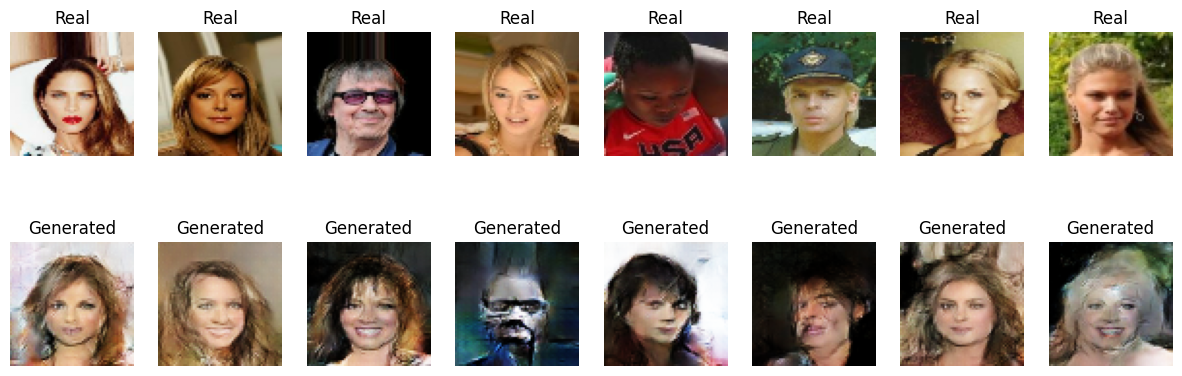

In [ ]:
def compare_real_and_generated(real_images, generator, num_samples=8):

    noise = tf.random.normal([num_samples, NOISE_DIM])
    generated_images = generator(noise, training=False)

    real_images = (real_images + 1) / 2
    generated_images = (generated_images + 1) / 2

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[0, i].imshow(real_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title('Real')
        axes[1, i].imshow(generated_images[i])
        axes[1, i].axis('off')
        axes[1, i].set_title('Generated')
    plt.show()

real_images = next(iter(celeba_dataset))
compare_real_and_generated(real_images[:8], generator, num_samples=8)


e

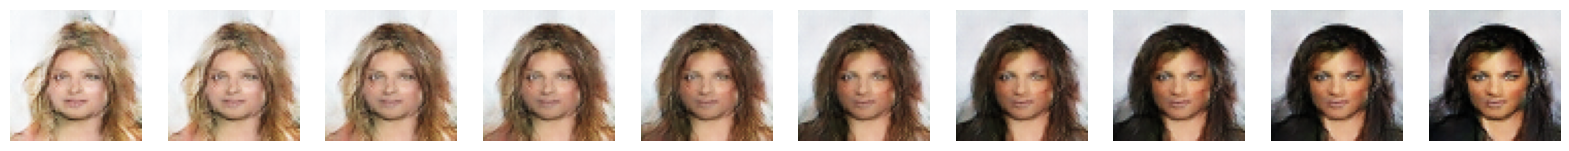

In [ ]:
def interpolate_vectors(vector1, vector2, steps=10):
    interpolated = []
    for alpha in np.linspace(0, 1, steps):
        interpolated.append((1 - alpha) * vector1 + alpha * vector2)
    return np.squeeze(np.array(interpolated, dtype=np.float32), axis=1)
def generate_interpolated_images(generator, steps=10):

    vector1 = tf.random.normal([1, NOISE_DIM])
    vector2 = tf.random.normal([1, NOISE_DIM])

    interpolated_vectors = interpolate_vectors(vector1.numpy(), vector2.numpy(), steps=steps)

    interpolated_vectors = tf.convert_to_tensor(interpolated_vectors)

    interpolated_images = generator(interpolated_vectors, training=False)

    fig, axes = plt.subplots(1, steps, figsize=(20, 5))
    for i in range(steps):
        axes[i].imshow((interpolated_images[i] + 1) / 2)
        axes[i].axis('off')
    plt.show()

generate_interpolated_images(generator, steps=10)


Latent Space Exploration Pair 1


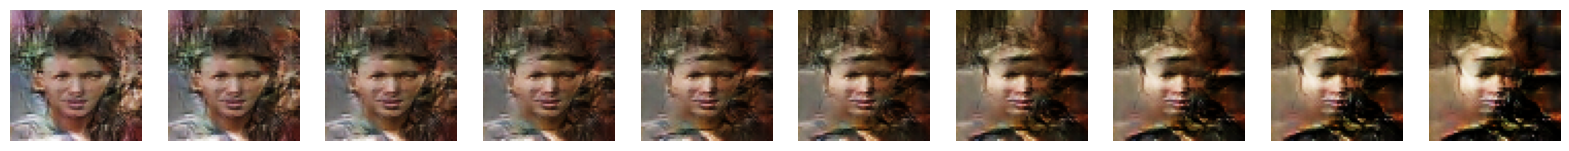

Latent Space Exploration Pair 2


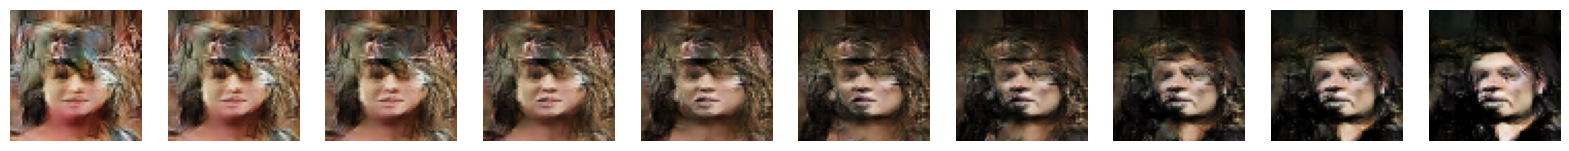

Latent Space Exploration Pair 3


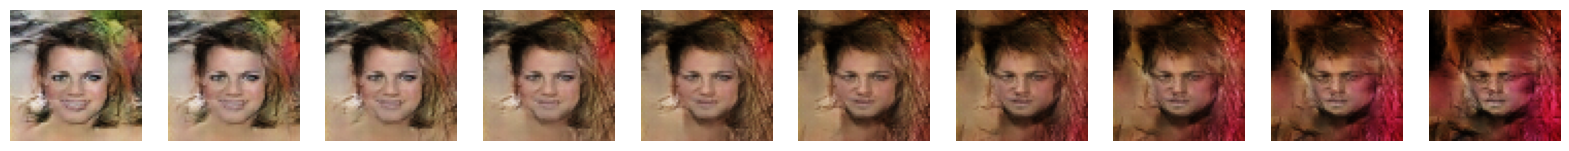

In [ ]:
def random_latent_space_exploration(generator, num_pairs=5, steps=10):
    for i in range(num_pairs):
        print(f"Latent Space Exploration Pair {i + 1}")
        generate_interpolated_images(generator, steps=steps)

random_latent_space_exploration(generator, num_pairs=3, steps=10)


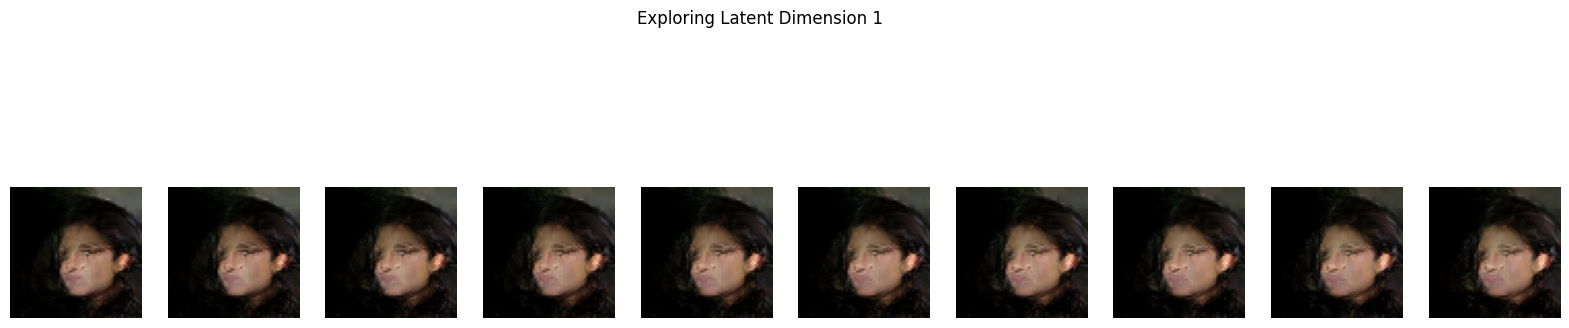

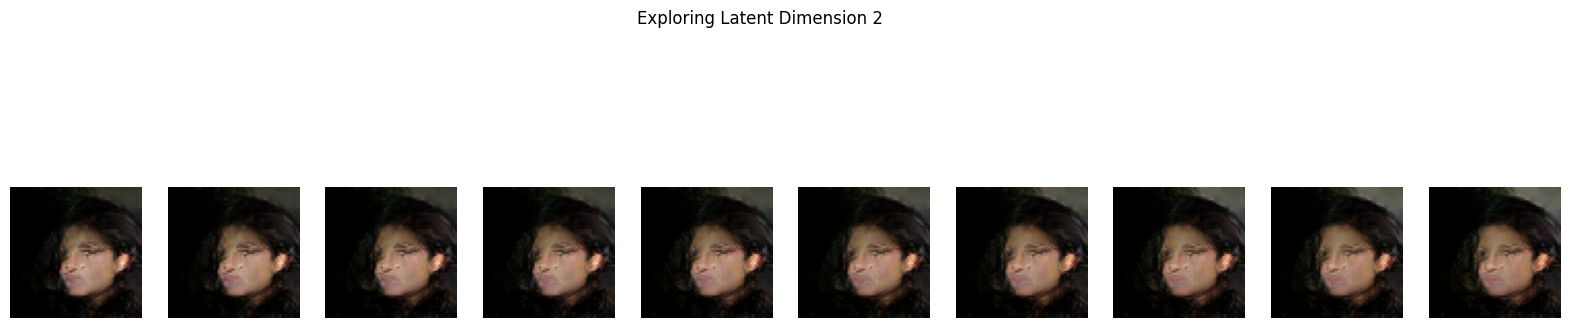

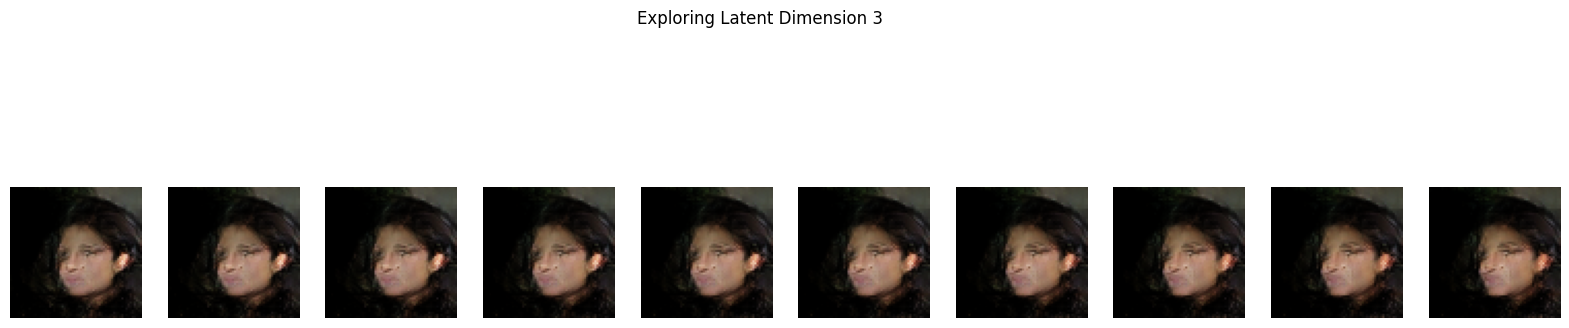

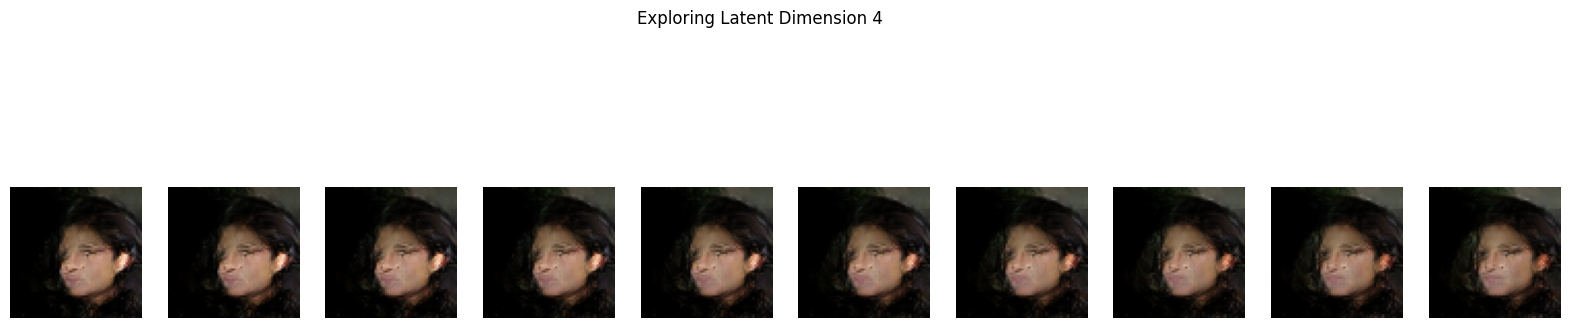

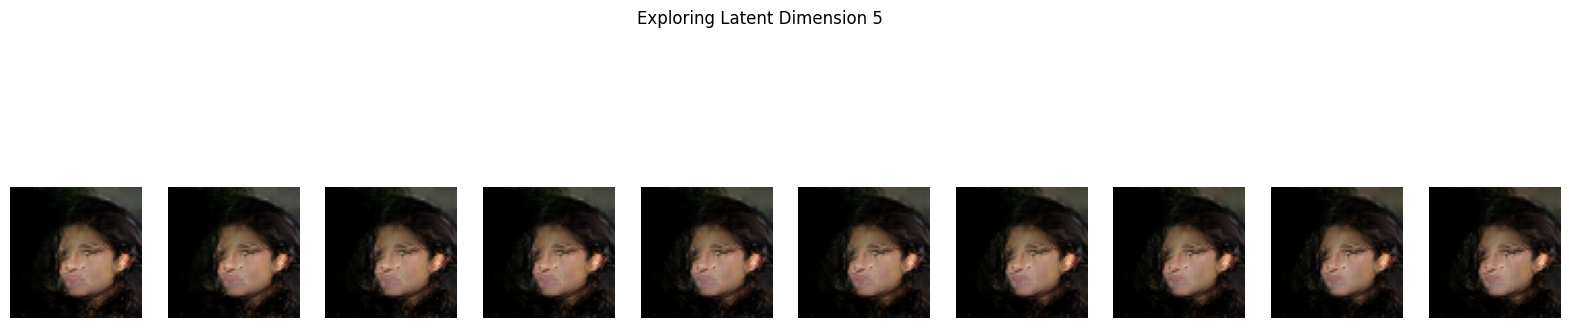

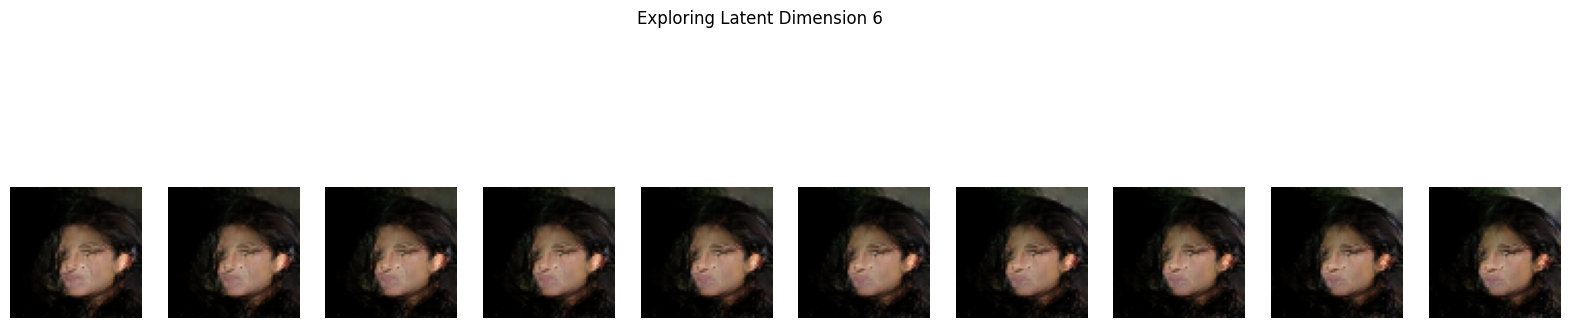

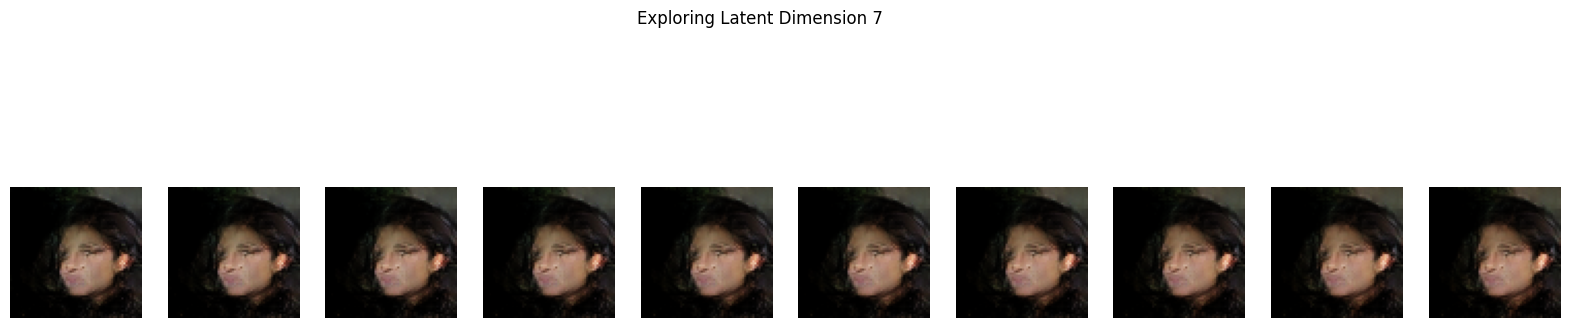

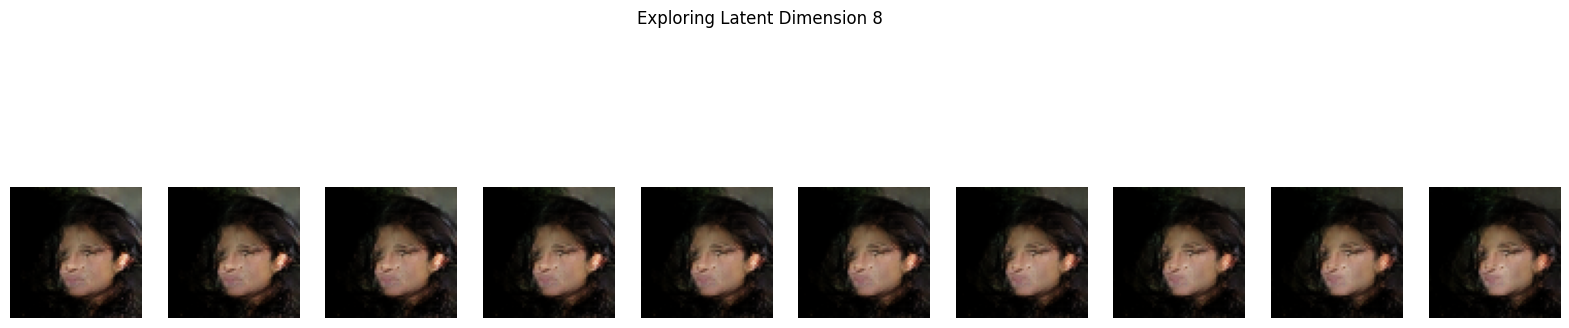

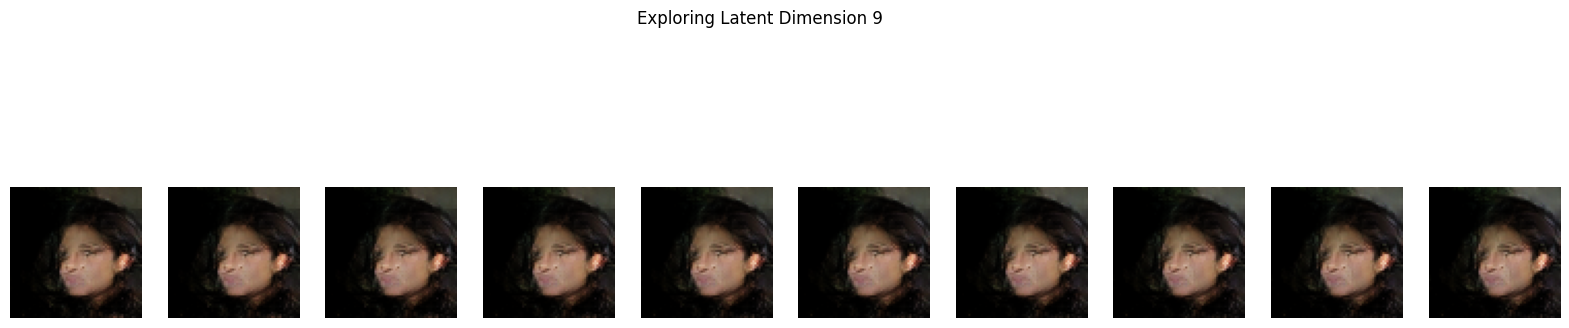

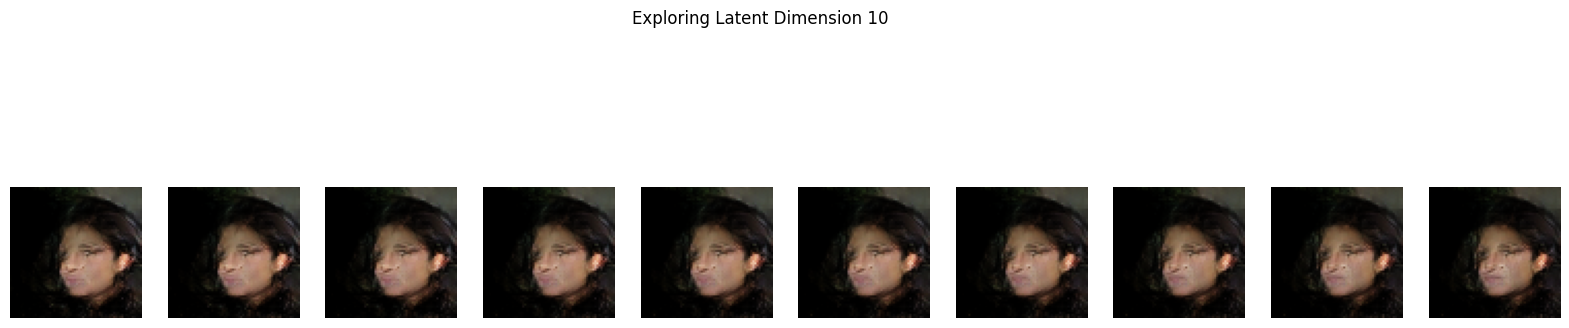

In [ ]:
def structured_latent_space_exploration(generator, steps=10):
    base_vector = tf.random.normal([1, NOISE_DIM])

    for dim in range(10):
        perturbed_vectors = []
        for alpha in np.linspace(-1, 1, steps):
            perturbed = base_vector.numpy()
            perturbed[0][dim] += alpha
            perturbed_vectors.append(perturbed)

        perturbed_images = generator(np.vstack(perturbed_vectors), training=False)

        fig, axes = plt.subplots(1, steps, figsize=(20, 5))
        for i in range(steps):
            axes[i].imshow((perturbed_images[i] + 1) / 2)
            axes[i].axis('off')
        plt.suptitle(f"Exploring Latent Dimension {dim + 1}")
        plt.show()

structured_latent_space_exploration(generator, steps=10)
